In [1]:
import os
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx
import pickle
from matplotlib import ticker

import sys

sys.path.append("../../src")

import stochastic_benchmark as SB
import bootstrap
import interpolate
import stats
from utils_ws import *

## Simulated Annealing (SA)

SA is an optimization algorithm that works by navigating the input space and evaluating the objective function (energy) similarly to hill climbing. The main difference is that SA implements a strategy to avoid getting stuck in local optima.

The general idea is to allow moves to a worse position, but in a structured way. When a candidate solution is selected, the probability of actually moving to the new position is determined by the change in the objective function and by a metric called **temperature**. When the temperature is high, the chance of performing a jump to a worse state increases, and the opposite happens when the temperature is low. By continuously decreasing the temperature during the execution of the algorithm, it can escape local optima during the first stages (high temperature), but it settles into a position towards the end of the execution (low temperature).

### Probability of Making a Jump

**Case 1:**
$$
\Delta E = E_{current} - E_{next} > 0
$$

It is always advantageous to move to a state with a better objective function. In this case, the probability is $P = 1$.

**Case 2:**
$$
\Delta E = E_{current} - E_{next} < 0
$$

In this case, the probability of taking the step is determined by:

$$
P = e^{-|\Delta E| / T}
$$

**Note:** This formulation applies to a minimization problem. To solve a maximization problem, the only change is that $\Delta E = E_{next} - E_{current}$.

### Temperature Decrease

The way the temperature decreases during the algorithm's execution varies between implementations. This is referred to as the temperature **schedule**, which is a function of time or the number of iterations.

**Note:** $\beta = 1 / T$ is also commonly used in the implementation of the algorithm.

Let's define a larger model, with 100 variables and random weights.

Assume that we are interested at the instance created with random weights $h_{i}, J_{i, j} \sim U[-1, +1]$.

### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(i, j) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$.

### Loading The Data

The following cells load data from Simulated Annealing runs performed on a problem instance with variations in the number of reads parameter (1, 10, 1000).

These runs were originally executed using the [QuboNotebooks Repository](https://github.com/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb).

In [2]:
current_path = os.getcwd()
pickle_path = os.path.join(current_path, 'results/')
if not(os.path.exists(pickle_path)):
    print('Results directory ' + pickle_path +
          ' does not exist. We will create it.')
    os.makedirs(pickle_path)
    !wget -O {pickle_path}results.zip -N -q "https://github.com/JuliaQUBO/QUBONotebooks/raw/main/notebooks_py/results.zip"

In [3]:
import zipfile
zip_name = os.path.join(pickle_path, 'results.zip')
overwrite_pickles = False
if os.path.exists(zip_name):
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(pickle_path)
    print('Results zip file has been extrated to ' + pickle_path)

Results zip file has been extrated to /home/jvpcms/purdue-internship/stochastic-benchmark-jvpcms/examples/Simulated_Annealing/results/


Convert results to the format expected by the Stochast Benchmark Framework

In [20]:
results_name = "all_results.pkl"
results_name = os.path.join(pickle_path, results_name)

results = pickle.load(open(results_name, "rb"))

sweeps = list(chain(np.arange(1, 250, 1), np.arange(250, 1001, 10)))
header_names = [
    'instance', 
    'boots', 
    'sweeps', 
    'reads',
    'schedule', 
    'Key=approx_ratio', 
    'ConfInt=lower_Key=approx_ratio', 
    'ConfInt=upper_Key=approx_ratio'
]

if not(os.path.exists("checkpoints")):
    os.makedirs("checkpoints")

for instance in results.keys():
    df = pd.DataFrame(columns=header_names)
    metric = "best"
    metric_ci = "bestci"
    schedule = "geometric"
    for reads in results[instance][metric][schedule].keys():
        boots = reads
        n_sweeps = len(results[instance][metric][schedule][reads])
        for sweep_index in range(n_sweeps):
            sweep = sweeps[sweep_index]

            aprox_ratio = results[instance][metric][schedule][reads][sweep_index]
            aprox_ratio_ci = results[instance][metric_ci][schedule][reads][sweep_index]
            aprox_ratio_ci_low = aprox_ratio_ci[1]
            aprox_ratio_ci_high = aprox_ratio_ci[0]

            df.loc[len(df)] = [
                instance, 
                boots, 
                sweep, 
                reads,
                schedule, 
                aprox_ratio, 
                aprox_ratio_ci_low, 
                aprox_ratio_ci_high
            ]

    instance_name = f"bootstrapped_results_inst={instance}.pkl"
    instance_path = os.path.join("checkpoints", instance_name)
    pickle.dump(df, open(instance_path, "wb"))


### Performance Metric

We are interested in the "approximation ratio" metric. In this particular problem, it is calculated as follows:

- First, we sample a subset from the input space and calculate the associated energies. Specifically, we use 1000 random bitstrings in this case.
- The best (minimum) energy found across the random sample is denoted as `minimum`, while the mean energy across the random sampling is denoted as `random`.
- The approximation ratio is calculated across an increasing number of sweeps of simulated annealing, where `found` is the best energy found at the current moment in the algorithm's execution.

$$
approximation\space ratio = \frac{found - random}{minimum - random}
$$

Even though it is (very) unlikely that we found the best solution during the random sampling, this metric is useful because it gives us a general idea of how good our currently found solution is.

More details are available at the [QuboNotebooks Repository](https://github.com/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb).

### Resource

In this analysis, we examine how the approximation ratio evolves as the number of sweeps increases during algorithm execution.

The number of sweeps serves as our resource metric. The objective is to achieve a high approximation ratio while minimizing the number of sweeps required (i.e., using fewer computational resources).

In [22]:
here = os.getcwd()
parameter_names = [
    "sweeps",
    "reads"
]  # think about whether iterations should be a parameter or not.
instance_cols = [
    "instance"
]  # indicates how instances should be grouped, default is ['instance']

## Response information
response_key = "approx_ratio"  # Column with the response
response_dir = 1  # whether we want to maximize (1) or minimize (-1), default is 1

## Optimizations informations
recover = True  # Whether we want to read dataframes when available, default is True
reduce_mem = True  # Whether we want to segment bootstrapping and interpolation to reduce memory usage, default is True
smooth = True  # Whether virtual best should be monontonized, default is True

sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    response_dir=response_dir,
    smooth=smooth,
)

In [23]:
shared_args = {
    "response_col": "approx_ratio",
    "resource_col": "resource",
    "response_dir": 1,
    "confidence_level": 68,
}
boots_range = [1, 10, 1000]
bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args, update_rule=lambda df: None
)
bs_iter_class = bootstrap.BSParams_range_iter()
bsParams_iter = bs_iter_class(bsParams, boots_range)
sb.run_Bootstrap(bsParams_iter)

In [24]:
# Interpolate
def resource_fcn(df):
    # print(df)
    return df["boots"] * df["sweeps"] * df["reads"]


iParams = interpolate.InterpolationParameters(resource_fcn, parameters=parameter_names)
sb.run_Interpolate(iParams)

100%|██████████| 975/975 [00:01<00:00, 574.75it/s]


In [25]:
# Set up Stats computations
train_test_split = 0.8
metrics = ["approx_ratio"]
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split)

100%|██████████| 464/464 [00:00<00:00, 1689.48it/s]


In [26]:
sb.run_baseline()

In [27]:
sb.run_ProjectionExperiment("TrainingStats", None, None)
sb.run_ProjectionExperiment("TrainingResults", None, None)

In [28]:
import plotting

plotting.monotone = True
sb.initPlotting()

100%|██████████| 82/82 [00:00<00:00, 1514.88it/s]


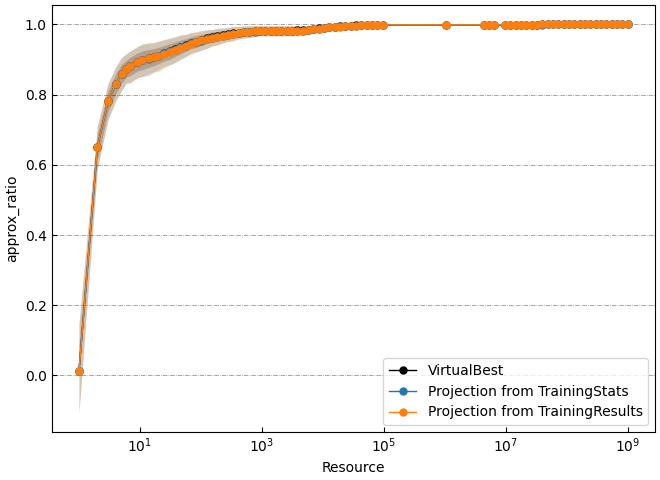

In [29]:
fig, axs = sb.plots.plot_performance()
fig.savefig("performance.png")

100%|██████████| 82/82 [00:00<00:00, 1852.65it/s]


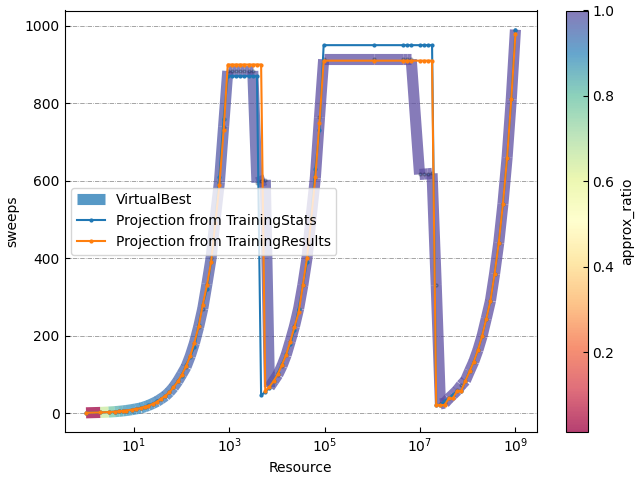

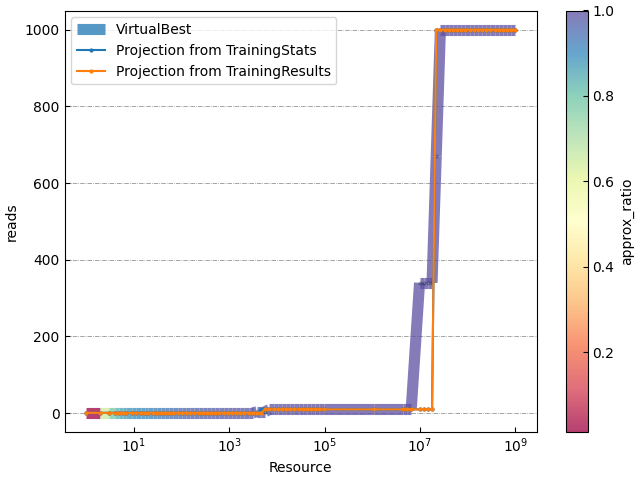

In [30]:
figs, axes = sb.plots.plot_parameters_separate()
for param, fig in figs.items():
    fig.savefig(param + ".png")